In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, f1_score, precision_score, recall_score)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
print("=== Fraud Detection: Logistic Regression Baseline ===")
print("=" * 50)

# STEP 1: Load and Prepare Data
print("\n1. Loading and preparing data...")

# Load the cleaned data
df = pd.read_csv('data/processed/cc_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Select only numerical features (exclude any categorical columns that might exist)
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numerical_features]

print(f"Using {len(numerical_features)} numerical features")
print(f"Class distribution: {y.value_counts().to_dict()}")

=== Fraud Detection: Logistic Regression Baseline ===

1. Loading and preparing data...
Dataset shape: (281918, 34)
Using 32 numerical features
Class distribution: {0: 281470, 1: 448}


In [4]:
# STEP 2: Train-Test Split
print("\n2. Performing stratified train-test split...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")


2. Performing stratified train-test split...
Training set: (225534, 32)
Test set: (56384, 32)
Training fraud rate: 0.0016
Test fraud rate: 0.0016


In [5]:
print("\n3. Handling class imbalance...")

# Calculate class weights
n_legit = (y_train == 0).sum()
n_fraud = (y_train == 1).sum()
total = n_legit + n_fraud

weight_legit = total / (2 * n_legit)
weight_fraud = total / (2 * n_fraud)

class_weights = {0: weight_legit, 1: weight_fraud}

print(f"Class weights: {class_weights}")
print(f"Fraud weight is {weight_fraud/weight_legit:.1f}x higher than legitimate weight")


3. Handling class imbalance...
Class weights: {0: np.float64(0.5007949337407184), 1: np.float64(314.99162011173183)}
Fraud weight is 629.0x higher than legitimate weight


In [7]:
# STEP 4: Train Logistic Regression Model
print("\n4. Training Logistic Regression model...")

# Initialize model with class weights
logreg = LogisticRegression(
    class_weight=class_weights,
    random_state=42,
    max_iter=1000,
    C=1.0,  # Regularization strength
    solver='liblinear'
)

# Train the model
logreg.fit(X_train, y_train)

print("Model training completed")
print(f"Model coefficients shape: {logreg.coef_.shape}")


4. Training Logistic Regression model...
Model training completed
Model coefficients shape: (1, 32)


In [8]:
# STEP 5: Make Predictions
print("\n5. Making predictions...")

# Get probability scores
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probability of fraud

# Predict with default threshold (0.5)
y_pred = logreg.predict(X_test)

print("Predictions generated")


5. Making predictions...
Predictions generated


In [9]:
# STEP 6: Evaluate Model Performance
print("\n6. Evaluating model performance...")

# Basic metrics with default threshold
print("\nPerformance with default threshold (0.5):")
print("=" * 40)

accuracy = logreg.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Avg Precision: {avg_precision:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Legit', 'Actual Fraud'], 
                    columns=['Predicted Legit', 'Predicted Fraud'])
print(cm_df)


6. Evaluating model performance...

Performance with default threshold (0.5):
Accuracy:  0.9735
Precision: 0.0540
Recall:    0.9444
F1-Score:  0.1021
ROC-AUC:   0.9964
Avg Precision: 0.6816

Confusion Matrix:
              Predicted Legit  Predicted Fraud
Actual Legit            54804             1490
Actual Fraud                5               85


In [10]:
# STEP 7: Threshold Tuning for Fraud Detection
print("\n7. Threshold tuning analysis...")

# Try different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precision_t = precision_score(y_test, y_pred_thresh)
    recall_t = recall_score(y_test, y_pred_thresh)
    f1_t = f1_score(y_test, y_pred_thresh)
    
    results.append({
        'threshold': threshold,
        'precision': precision_t,
        'recall': recall_t,
        'f1_score': f1_t
    })

results_df = pd.DataFrame(results)
print("\nPerformance across different thresholds:")
print(results_df.round(4))

# Find optimal threshold based on F1-score
optimal_idx = results_df['f1_score'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_f1 = results_df.loc[optimal_idx, 'f1_score']

print(f"\nOptimal threshold: {optimal_threshold:.2f} (F1-score: {optimal_f1:.4f})")


7. Threshold tuning analysis...

Performance across different thresholds:
   threshold  precision  recall  f1_score
0        0.1     0.0067  1.0000    0.0133
1        0.2     0.0138  1.0000    0.0273
2        0.3     0.0238  0.9889    0.0465
3        0.4     0.0372  0.9778    0.0716
4        0.5     0.0540  0.9444    0.1021
5        0.6     0.0759  0.9222    0.1403
6        0.7     0.1088  0.9222    0.1946

Optimal threshold: 0.70 (F1-score: 0.1946)



8. Creating performance visualizations...


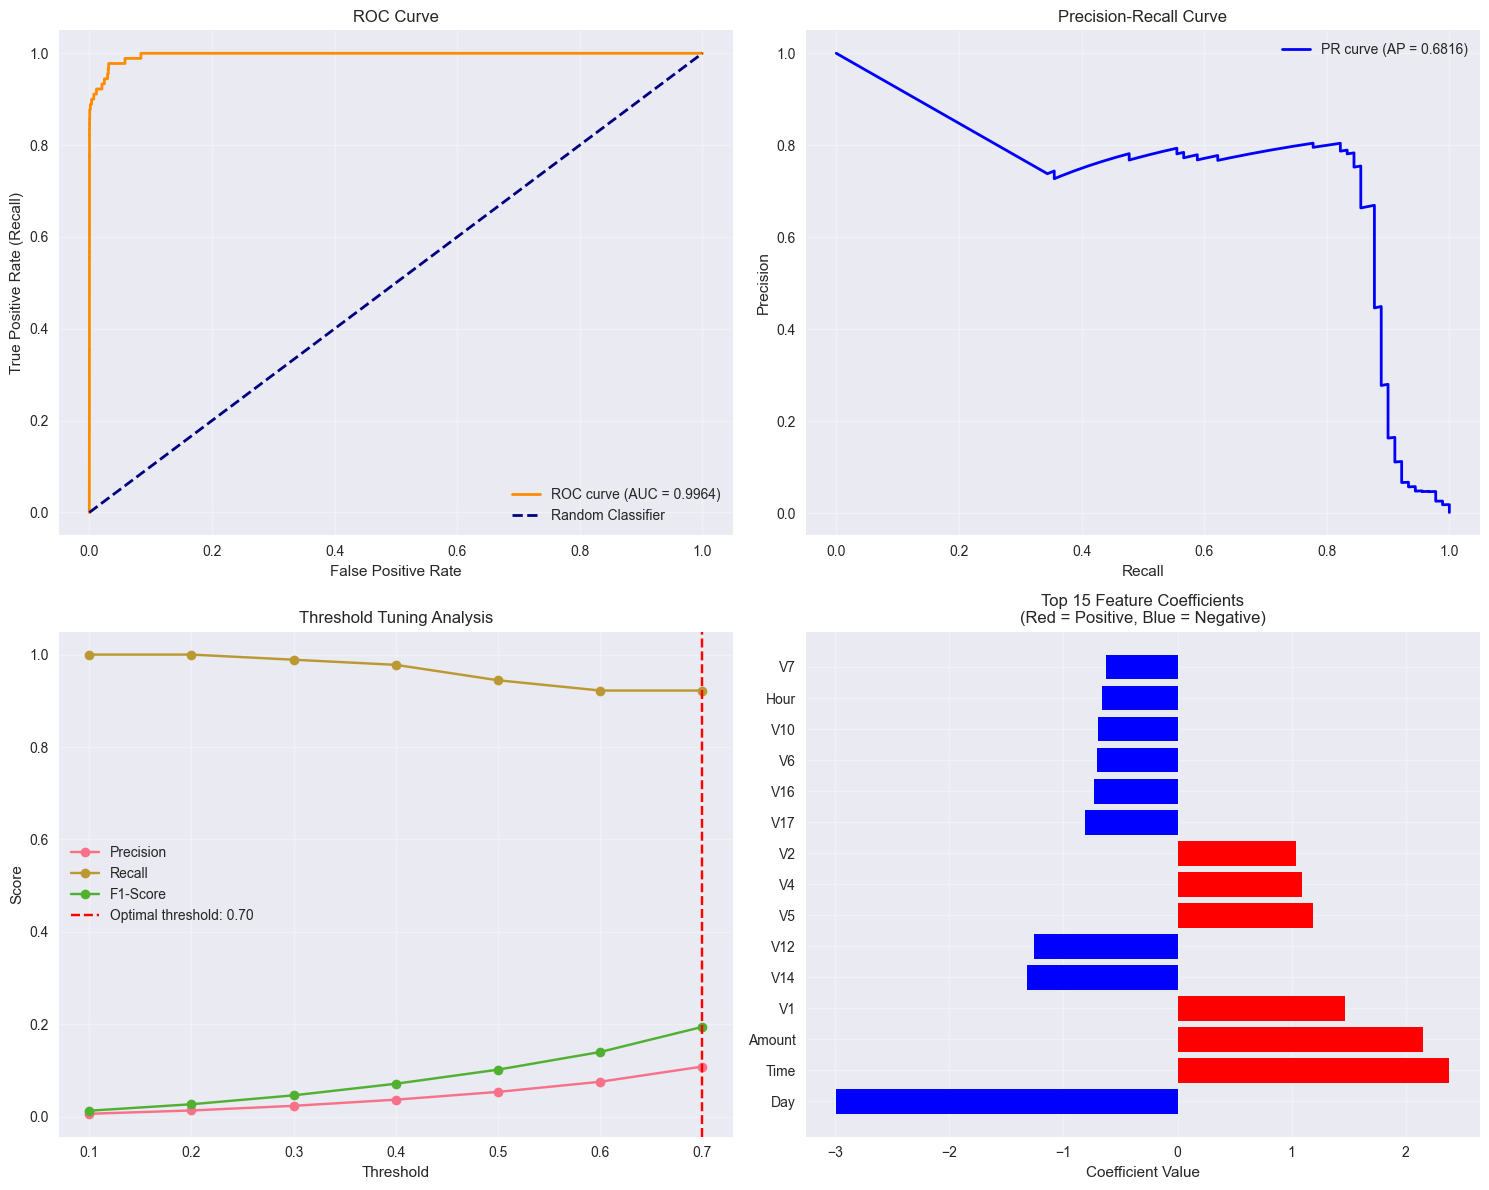

In [11]:
# STEP 8: Visualization
print("\n8. Creating performance visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate (Recall)')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
axes[0,1].plot(recall_vals, precision_vals, color='blue', lw=2, 
               label=f'PR curve (AP = {avg_precision:.4f})')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Threshold Analysis
axes[1,0].plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision')
axes[1,0].plot(results_df['threshold'], results_df['recall'], 'o-', label='Recall')
axes[1,0].plot(results_df['threshold'], results_df['f1_score'], 'o-', label='F1-Score')
axes[1,0].axvline(optimal_threshold, color='red', linestyle='--', 
                  label=f'Optimal threshold: {optimal_threshold:.2f}')
axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Threshold Tuning Analysis')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': logreg.coef_[0],
    'abs_coefficient': np.abs(logreg.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

# Plot top 15 features
top_features = feature_importance.head(15)
colors = ['red' if x > 0 else 'blue' for x in top_features['coefficient']]
axes[1,1].barh(range(len(top_features)), top_features['coefficient'], color=colors)
axes[1,1].set_yticks(range(len(top_features)))
axes[1,1].set_yticklabels(top_features['feature'])
axes[1,1].set_xlabel('Coefficient Value')
axes[1,1].set_title('Top 15 Feature Coefficients\n(Red = Positive, Blue = Negative)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# STEP 9: Model Interpretation
print("\n9. Model interpretation...")

print("\nTop 10 features influencing fraud prediction:")
print("=" * 50)
for i, row in feature_importance.head(10).iterrows():
    direction = "INCREASES fraud probability" if row['coefficient'] > 0 else "DECREASES fraud probability"
    print(f"{row['feature']:15}: {row['coefficient']:8.4f} ({direction})")



9. Model interpretation...

Top 10 features influencing fraud prediction:
Day            :  -2.9889 (DECREASES fraud probability)
Time           :   2.3811 (INCREASES fraud probability)
Amount         :   2.1528 (INCREASES fraud probability)
V1             :   1.4644 (INCREASES fraud probability)
V14            :  -1.3193 (DECREASES fraud probability)
V12            :  -1.2610 (DECREASES fraud probability)
V5             :   1.1869 (INCREASES fraud probability)
V4             :   1.0916 (INCREASES fraud probability)
V2             :   1.0358 (INCREASES fraud probability)
V17            :  -0.8127 (DECREASES fraud probability)


In [13]:
# STEP 10: Cross-Validation
print("\n10. Cross-validation performance...")

cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



10. Cross-validation performance...
Cross-validation ROC-AUC scores: [0.99281295 0.98240011 0.97310703 0.96207148 0.95081072]
Mean CV ROC-AUC: 0.9722 (+/- 0.0295)


In [16]:
# STEP 11: Save Model and Results
print("\n11. Saving model and results...")

import os
os.makedirs('models', exist_ok=True)
os.makedirs('reports/figures', exist_ok=True)

# Save the trained model
joblib.dump(logreg, 'models/logistic_regression.pkl')
print("Model saved: models/logistic_regression.pkl")

# Save feature importance
feature_importance.to_csv('reports/logistic_regression_feature_importance.csv', index=False)
print("Feature importance saved: reports/logistic_regression_feature_importance.csv")

# Save performance results
performance_report = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'avg_precision': avg_precision,
    'optimal_threshold': optimal_threshold,
    'cv_mean_roc_auc': cv_scores.mean(),
    'cv_std_roc_auc': cv_scores.std()
}

performance_df = pd.DataFrame([performance_report])
performance_df.to_csv('reports/logistic_regression_performance.csv', index=False)
print("Performance report saved: reports/logistic_regression_performance.csv")



11. Saving model and results...
Model saved: models/logistic_regression.pkl
Feature importance saved: reports/logistic_regression_feature_importance.csv
Performance report saved: reports/logistic_regression_performance.csv


In [17]:
# STEP 12: Final Summary
print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)

print(f"\nMODEL PERFORMANCE:")
print(f"• Recall (Frauds Caught): {recall:.1%}")
print(f"• Precision (Accuracy of Fraud Alerts): {precision:.1%}")
print(f"• F1-Score: {f1:.4f}")
print(f"• ROC-AUC: {roc_auc:.4f}")

print(f"\nBUSINESS IMPACT:")
frauds_caught = cm[1, 1]  # True Positives
frauds_missed = cm[1, 0]  # False Negatives
false_alarms = cm[0, 1]   # False Positives

print(f"• Frauds detected: {frauds_caught}/{frauds_caught + frauds_missed} ({recall:.1%})")
print(f"• False alarms: {false_alarms} legitimate transactions flagged")
print(f"• Optimal threshold for business: {optimal_threshold:.2f}")

print(f"\nKEY INSIGHTS:")
top_3_fraud_indicators = feature_importance.head(3)['feature'].tolist()
top_3_legit_indicators = feature_importance.tail(3)['feature'].tolist()

print(f"• Top fraud indicators: {', '.join(top_3_fraud_indicators)}")
print(f"• Top legitimate indicators: {', '.join(top_3_legit_indicators)}")


FINAL SUMMARY

MODEL PERFORMANCE:
• Recall (Frauds Caught): 94.4%
• Precision (Accuracy of Fraud Alerts): 5.4%
• F1-Score: 0.1021
• ROC-AUC: 0.9964

BUSINESS IMPACT:
• Frauds detected: 85/90 (94.4%)
• False alarms: 1490 legitimate transactions flagged
• Optimal threshold for business: 0.70

KEY INSIGHTS:
• Top fraud indicators: Day, Time, Amount
• Top legitimate indicators: V24, V9, V25
